In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

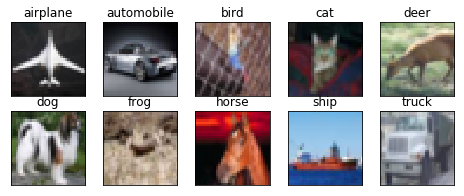

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### ENAS on Cifar 10

In [0]:
from keras.layers.convolutional import DepthwiseConv2D


def depth_wise_sep_conv(no_of_channels, kernel_size, inpt):
  depth_sep_conv_1=DepthwiseConv2D(kernel_size,padding='same',activation='relu')(inpt)
  depth_sep_conv_2 = Conv2D(no_of_channels, (1,1), strides=(1,1), padding='same')(depth_sep_conv_1)
  batchnrm = BatchNormalization()(depth_sep_conv_2)
  depthwise_output = ReLU()(batchnrm)
  print(depthwise_output.shape)
  return depthwise_output

In [0]:
def normal_conv(no_of_channels, kernel_size, inpt):
  conv = Conv2D(no_of_channels, kernel_size, padding='same')(inpt)
  batchnrm = BatchNormalization()(conv)
  conv_output = ReLU()(batchnrm)
  
  return conv_output

In [0]:
import tensorflow as tf
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=32)
  
  

In [76]:

from keras.layers import Input, Conv2D, ReLU, SeparableConv2D, BatchNormalization, Flatten, MaxPooling2D, Lambda, Activation
from keras.layers.merge import concatenate
from keras.models import Model

input = Input(shape=(32, 32, 3,))

seperable_1 = depth_wise_sep_conv(32, 5, input) 
convolution_1 = normal_conv(32, 5, seperable_1) 
convolution_2 = normal_conv(32, 5, convolution_1)

concatenation_1 = concatenate([seperable_1, convolution_2])
seperable_2 = depth_wise_sep_conv(32, 5, concatenation_1)

concatenation_2 = concatenate([seperable_1, seperable_1]) 
maxpool_1 = MaxPooling2D(pool_size=(2, 2), padding ="same", strides=(1,1))(concatenation_2)

seperable_3 = depth_wise_sep_conv(32, 3, maxpool_1)


concatenation_3 = concatenate([seperable_1, seperable_2, seperable_3])

convolution_3 = normal_conv(32, 5, concatenation_3)
concatenation_4 = concatenate([convolution_2, convolution_3, seperable_3, seperable_2])

seperable_4 = depth_wise_sep_conv(32, 3, concatenation_4)
concatenation_5 = concatenate([convolution_2, convolution_3, seperable_1, seperable_2, seperable_3, seperable_4])

seperable_5 = depth_wise_sep_conv(32, 5, concatenation_5)
concatenation_6 = concatenate([seperable_5, seperable_4, seperable_3, seperable_2, seperable_1])

maxpool_2 = MaxPooling2D(pool_size=(2,2), padding = 'same', strides=(1,1))(concatenation_6)
concatenation_7 = concatenate([convolution_3, concatenation_6])
convolution_4 = normal_conv(32, 5, concatenation_7)

concatenation_8 = concatenate([convolution_4, seperable_4, convolution_1, seperable_1])
seperable_6 = depth_wise_sep_conv(32, 5, concatenation_8)

concatenation_9 = concatenate([seperable_6, convolution_4, seperable_3, convolution_2, convolution_1])
convolution_5 = normal_conv(32, 3, concatenation_9)

concatenation_10 = concatenate([convolution_5, convolution_2, seperable_4, seperable_6, seperable_2, seperable_1, seperable_3])
seperable_7 = depth_wise_sep_conv(32, 5, concatenation_10)

concatenation_11 = concatenate([seperable_7, seperable_4, seperable_6, seperable_2])

convolution_6 = Conv2D(10, 1) (concatenation_11)
convolution_6 = BatchNormalization()(convolution_6)
convolution_6 = ReLU()(convolution_6)

convolution_7 = Conv2D(10, 32)(convolution_6)
convolution_7 = BatchNormalization()(convolution_7)
convolution_7 = ReLU()(convolution_7)


Final = Flatten()(convolution_7)
output = Activation('softmax')(Final)


model = Model(inputs=[input], outputs=[output])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 32, 32, 32)


In [77]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
depthwise_conv2d_103 (Depthwise (None, 32, 32, 3)    78          input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 32, 32, 32)   128         depthwise_conv2d_103[0][0]       
__________________________________________________________________________________________________
batch_normalization_209 (BatchN (None, 32, 32, 32)   128         conv2d_201[0][0]                 
__________________________________________________________________________________________________
re_lu_205 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
195/195 [==============================] - 93s 479ms/step - loss: 1.5480 - acc: 0.5175 - val_loss: 1.5342 - val_acc: 0.4970
Epoch 2/100
195/195 [==============================] - 75s 383ms/step - loss: 1.1762 - acc: 0.6561 - val_loss: 1.6026 - val_acc: 0.4588
Epoch 3/100
195/195 [==============================] - 74s 381ms/step - loss: 0.9916 - acc: 0.7131 - val_loss: 1.1278 - val_acc: 0.6475
Epoch 4/100
195/195 [==============================] - 74s 382ms/step - loss: 0.8592 - acc: 0.7516 - val_loss: 1.2400 - val_acc: 0.5911
Epoch 5/100
195/195 [==============================] - 74s 382ms/step - loss: 0.7526 - acc: 0.7847 - val_loss: 1.1540 - val_acc: 0.6207
Epoch 6/100
195/195 [==============================] - 74s 382ms/step - loss: 0.6540 - acc: 0.8184 - val_loss: 1.3251 - val_acc: 0.5686
Epoch 7/100
195/195 [==============================] - 75s 382ms/step - loss: 0.5636 - acc: 0.8501 - val_loss: 1.1876 - val_acc: 0.6051
Epoch 8/100
195/195 [===========================

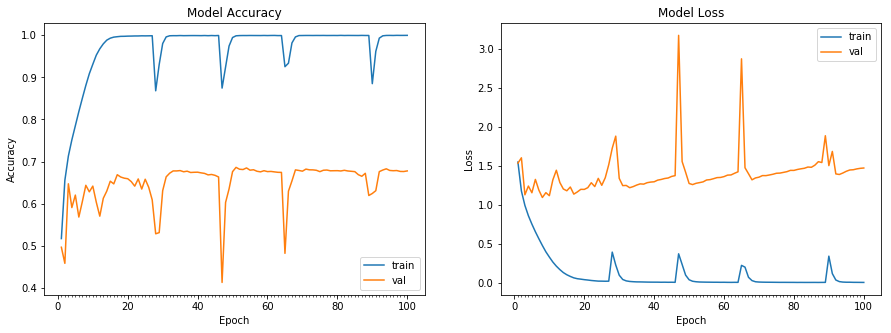

Accuracy on test data is: 67.80


In [79]:
# ENAS log
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))